# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.


In [125]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing as p
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import random 

# magic word for producing visualizations in notebook
%matplotlib inline

'''
Import note: The classroom currently uses sklearn version 0.19.
If you need to use an imputer, it is available in sklearn.preprocessing.Imputer,
instead of sklearn.impute as in newer versions of sklearn.
'''

'\nImport note: The classroom currently uses sklearn version 0.19.\nIf you need to use an imputer, it is available in sklearn.preprocessing.Imputer,\ninstead of sklearn.impute as in newer versions of sklearn.\n'

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.


In [2]:
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv', sep=";")

feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', sep=";")

In [3]:
print(azdias.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Data columns (total 85 columns):
AGER_TYP                 891221 non-null int64
ALTERSKATEGORIE_GROB     891221 non-null int64
ANREDE_KZ                891221 non-null int64
CJT_GESAMTTYP            886367 non-null float64
FINANZ_MINIMALIST        891221 non-null int64
FINANZ_SPARER            891221 non-null int64
FINANZ_VORSORGER         891221 non-null int64
FINANZ_ANLEGER           891221 non-null int64
FINANZ_UNAUFFAELLIGER    891221 non-null int64
FINANZ_HAUSBAUER         891221 non-null int64
FINANZTYP                891221 non-null int64
GEBURTSJAHR              891221 non-null int64
GFK_URLAUBERTYP          886367 non-null float64
GREEN_AVANTGARDE         891221 non-null int64
HEALTH_TYP               891221 non-null int64
LP_LEBENSPHASE_FEIN      886367 non-null float64
LP_LEBENSPHASE_GROB      886367 non-null float64
LP_FAMILIE_FEIN          886367 non-null float64
LP_FAMILIE_GROB          886367 n

In [4]:
print(azdias.head(10))

   AGER_TYP  ALTERSKATEGORIE_GROB  ANREDE_KZ  CJT_GESAMTTYP  \
0        -1                     2          1            2.0   
1        -1                     1          2            5.0   
2        -1                     3          2            3.0   
3         2                     4          2            2.0   
4        -1                     3          1            5.0   
5         3                     1          2            2.0   
6        -1                     2          2            5.0   
7        -1                     1          1            3.0   
8        -1                     3          1            3.0   
9        -1                     3          2            4.0   

   FINANZ_MINIMALIST  FINANZ_SPARER  FINANZ_VORSORGER  FINANZ_ANLEGER  \
0                  3              4                 3               5   
1                  1              5                 2               5   
2                  1              4                 1               2   
3             

In [6]:
print(feat_info.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85 entries, 0 to 84
Data columns (total 4 columns):
attribute             85 non-null object
information_level     85 non-null object
type                  85 non-null object
missing_or_unknown    85 non-null object
dtypes: object(4)
memory usage: 2.7+ KB
None


In [7]:
print(feat_info)

                attribute information_level         type missing_or_unknown
0                AGER_TYP            person  categorical             [-1,0]
1    ALTERSKATEGORIE_GROB            person      ordinal           [-1,0,9]
2               ANREDE_KZ            person  categorical             [-1,0]
3           CJT_GESAMTTYP            person  categorical                [0]
4       FINANZ_MINIMALIST            person      ordinal               [-1]
5           FINANZ_SPARER            person      ordinal               [-1]
6        FINANZ_VORSORGER            person      ordinal               [-1]
7          FINANZ_ANLEGER            person      ordinal               [-1]
8   FINANZ_UNAUFFAELLIGER            person      ordinal               [-1]
9        FINANZ_HAUSBAUER            person      ordinal               [-1]
10              FINANZTYP            person  categorical               [-1]
11            GEBURTSJAHR            person      numeric                [0]
12        GF

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

#### Step 1.1.1: Convert Missing Value Codes to NaNs


In [9]:
for i in range(len(feat_info)):
    l = feat_info.iloc[i,3].strip('][').split(',')
    if l[0] != '':
        for j in range(len(l)):
            try:
                l[j] = int(l[j])
            except:
                pass 
        azdias.iloc[:,i] = azdias.iloc[:,i].replace(l, np.nan)
    

#### Step 1.1.2: Assess Missing Data in Each Column


(array([ 31.,   1.,   0.,   0.,   0.,   0.,   0.,   7.,   8.,  10.,   6.,
          7.,   6.,   0.,   1.,   2.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.]),
 array([      0.        ,   10459.54117647,   20919.08235294,
          31378.62352941,   41838.16470588,   52297.70588235,
          62757.24705882,   73216.78823529,   83676.32941176,
          94135.87058824,  104595.41176471,  115054.95294118,
         125514.49411765,  135974.03529412,  146433.57647059,
         156893.11764706,  167352.65882353,  177812.2       ,
         188271.74117647,  198731.28235294,  209190.

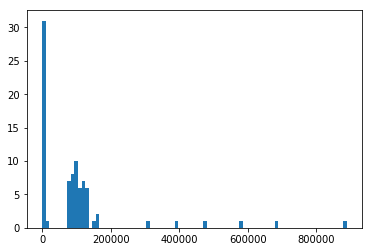

In [10]:
missing_data = azdias.isna().sum(axis=0)
plt.hist(missing_data.values, bins = 85)

In [11]:
outlier_indices = np.nonzero(missing_data.values > 250000)[0].tolist()
outlier_cols = missing_data.index[outlier_indices].tolist()
print(outlier_cols)

['AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 'ALTER_HH', 'KK_KUNDENTYP', 'KBA05_BAUMAX']


In [12]:
azdias = azdias.drop(outlier_cols, axis=1)
azdias.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,2.0,1,2.0,3,4,3,5,5,3,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.0,2,5.0,1,5,2,5,4,5,1,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,3.0,2,3.0,1,4,1,2,3,5,1,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,4.0,2,2.0,4,2,5,2,1,2,6,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,3.0,1,5.0,4,3,4,1,3,2,5,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


#### Discussion 1.1.2: Assess Missing Data in Each Column

The single largest value of missing data that most columns shared was pretty close to zero. There is also a significant amount of columns that have missing values that range from around 100,000 to 180,000 and very few that had more missing values than 200,000, six to be precise. ['AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 'ALTER_HH', 'KK_KUNDENTYP', 'KBA05_BAUMAX'] So I had those columns removed from the dataset. 

#### Step 1.1.3: Assess Missing Data in Each Row


(array([  6.97109000e+05,   7.76340000e+04,   1.28010000e+04,
          9.53300000e+03,   8.29000000e+02,   1.55000000e+02,
          1.40160000e+04,   5.03100000e+03,   2.80380000e+04,
          4.60750000e+04]),
 array([  0. ,   4.9,   9.8,  14.7,  19.6,  24.5,  29.4,  34.3,  39.2,
         44.1,  49. ]),
 <a list of 10 Patch objects>)

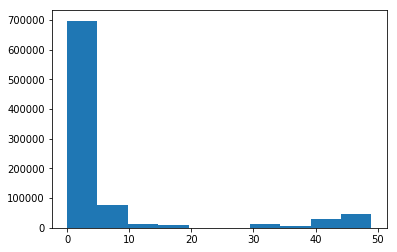

In [13]:
missing_data_rows = azdias.isna().sum(axis=1)
plt.hist(missing_data_rows.values)

In [14]:
rows_nan_less_than_10 = np.nonzero(missing_data_rows.values <= 10)[0].tolist()
rows_nan_more_than_10 = np.nonzero(missing_data_rows.values > 10)[0].tolist()

In [15]:
def compare_dist(col):
    f, axes = plt.subplots(1, 2, figsize=(5, 5))
    print(axes)
    sns.countplot(x = col, data=azdias.iloc[rows_nan_less_than_10], ax=axes[0])
    sns.countplot(x = col, data=azdias.iloc[rows_nan_more_than_10], ax=axes[1])
    plt.tight_layout()


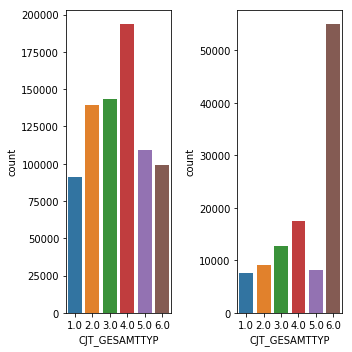

In [16]:
compare_dist('CJT_GESAMTTYP')

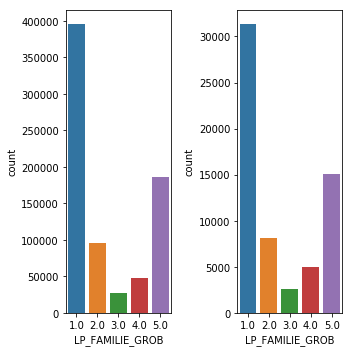

In [17]:
compare_dist('LP_FAMILIE_GROB')

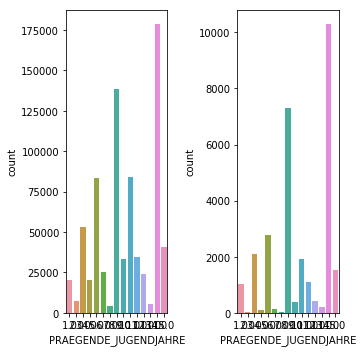

In [18]:
compare_dist('PRAEGENDE_JUGENDJAHRE')

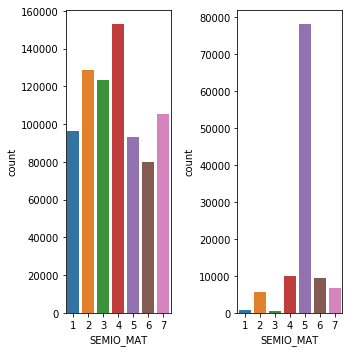

In [19]:
compare_dist('SEMIO_MAT')

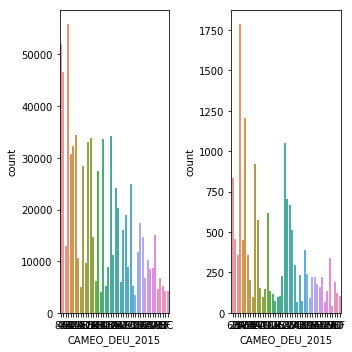

In [20]:
compare_dist('CAMEO_DEU_2015')

#### Discussion 1.1.3: Assess Missing Data in Each Row

Based on the historgram, it looks like the majority of the data points have fewer than 10 missing values, so I split the data based on whether they had less than 10 missing values or had more than 10 missing values. I plotted the distribution of the two splits for a couple different columns to compare the distributions between rows that had less than 10 missing values and rows that had more than 10 missing values. From the plots above, we can see that for most of the columns, the rows that had more than 10 missing values resulted in a distribution quite different from the rows that had less than 10 missing values.

### Step 1.2: Select and Re-Encode Features


In [21]:
n_mixed = np.sum(feat_info['type'] == 'mixed')
n_cat = np.sum(feat_info['type'] == 'categorical')
n_ordinal = np.sum(feat_info['type'] == 'ordinal')
n_num = np.sum(feat_info['type'] == 'numeric')
n_interval = np.sum(feat_info['type'] == 'interval')
print("n_mixed:", n_mixed)
print("n_cat:", n_cat)
print("n_ordinal:", n_ordinal)
print("n_num:", n_num)
print("n_interval:", n_interval)

n_mixed: 7
n_cat: 21
n_ordinal: 49
n_num: 7
n_interval: 1


#### Step 1.2.1: Re-Encode Categorical Features


In [22]:
feat_info[feat_info['type'] == 'categorical']

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
10,FINANZTYP,person,categorical,[-1]
12,GFK_URLAUBERTYP,person,categorical,[]
13,GREEN_AVANTGARDE,person,categorical,[]
17,LP_FAMILIE_FEIN,person,categorical,[0]
18,LP_FAMILIE_GROB,person,categorical,[0]
19,LP_STATUS_FEIN,person,categorical,[0]
20,LP_STATUS_GROB,person,categorical,[0]


In [23]:
cols_to_drop = feat_info[feat_info['type'] == 'categorical']['attribute'].tolist()
[cols_to_drop.remove(x) for x in ['AGER_TYP', 'TITEL_KZ', 'ANREDE_KZ', 'GREEN_AVANTGARDE', 'SOHO_KZ', 'VERS_TYP', 'KK_KUNDENTYP']]
cols_to_drop

['CJT_GESAMTTYP',
 'FINANZTYP',
 'GFK_URLAUBERTYP',
 'LP_FAMILIE_FEIN',
 'LP_FAMILIE_GROB',
 'LP_STATUS_FEIN',
 'LP_STATUS_GROB',
 'NATIONALITAET_KZ',
 'SHOPPER_TYP',
 'ZABEOTYP',
 'GEBAEUDETYP',
 'OST_WEST_KZ',
 'CAMEO_DEUG_2015',
 'CAMEO_DEU_2015']

In [24]:
azdias = pd.concat([azdias, pd.get_dummies(azdias['FINANZTYP'], prefix='FINANZTYP')], axis=1)
azdias = pd.concat([azdias, pd.get_dummies(azdias['LP_FAMILIE_FEIN'], prefix='LP_FAMILIE_FEIN')], axis=1)

azdias = azdias.drop(cols_to_drop, axis=1)

In [25]:
azdias.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,LP_FAMILIE_FEIN_2.0,LP_FAMILIE_FEIN_3.0,LP_FAMILIE_FEIN_4.0,LP_FAMILIE_FEIN_5.0,LP_FAMILIE_FEIN_6.0,LP_FAMILIE_FEIN_7.0,LP_FAMILIE_FEIN_8.0,LP_FAMILIE_FEIN_9.0,LP_FAMILIE_FEIN_10.0,LP_FAMILIE_FEIN_11.0
0,2.0,1,3,4,3,5,5,3,0,NaN,...,1,0,0,0,0,0,0,0,0,0
1,1.0,2,1,5,2,5,4,5,0,3.0,...,0,0,0,1,0,0,0,0,0,0
2,3.0,2,1,4,1,2,3,5,1,3.0,...,0,0,0,0,0,0,0,0,0,0
3,4.0,2,4,2,5,2,1,2,0,2.0,...,0,0,0,0,0,0,0,0,0,0
4,3.0,1,4,3,4,1,3,2,0,3.0,...,0,0,0,0,0,0,0,0,1,0


#### Discussion 1.2.1: Re-Encode Categorical Features

After checking the data, I found that the binary column that was encoded with letters contained information on whether the person lived on the east or west side of germany. I don't location has a great impact on whether these people will be consumers or not since the company performs mail-order sales, so I left that column out. I also didn't want to clutter the dataset that much, so I only one-hot encoded a few categorical columns. My reasoning is that things like energy consumption don't seem very related to whether or not they would be potential customers and information like vacation habits may be obtained from their finance type. All in all, I simply encoded finance type (FINANZTYP) and family type rough categorization (LP_FAMILIE_GROB).

#### Step 1.2.2: Engineer Mixed-Type Features


In [26]:
feat_info[feat_info['type'] == 'mixed']

,attribute,information_level,type,missing_or_unknown
15,LP_LEBENSPHASE_FEIN,person,mixed,[0]
16,LP_LEBENSPHASE_GROB,person,mixed,[0]
22,PRAEGENDE_JUGENDJAHRE,person,mixed,"[-1,0]"
56,WOHNLAGE,building,mixed,[-1]
59,CAMEO_INTL_2015,microcell_rr4,mixed,"[-1,XX]"
64,KBA05_BAUMAX,microcell_rr3,mixed,"[-1,0]"
79,PLZ8_BAUMAX,macrocell_plz8,mixed,"[-1,0]"


In [27]:
def label_decade(row):
    val = row['PRAEGENDE_JUGENDJAHRE']
    if val == 1 or val == 2:
        return 1
    if val == 3 or val == 4:
        return 2
    if val >= 5 and val <= 7:
        return 3
    if val == 8 or val == 9:
        return 4
    if val >= 10 and val <= 13:
        return 5
    if val == 14 or val == 15:
        return 6


In [28]:
decade = azdias.apply(label_decade, axis=1)

In [29]:
def label_movement(row):
    val = row['PRAEGENDE_JUGENDJAHRE']
    mainstream = [1, 3, 5, 8, 10, 12, 14]
    if val in mainstream:
        return 0
    if not np.isnan(val):
        return 1

In [30]:
movement = azdias.apply(label_movement, axis=1)

In [31]:
def label_wealth(row):
    val = row['CAMEO_INTL_2015']
    try:
        val = int(val) // 10
        return int(val)
    except:
        return val
wealth = azdias.apply(label_wealth, axis=1)

In [32]:
def label_lifestage(row):
    val = row['CAMEO_INTL_2015']
    try:
        val = int(val) % 10
        return int(val)
    except:
        return val
lifestage = azdias.apply(label_lifestage, axis=1)

#### Discussion 1.2.2: Engineer Mixed-Type Features

The other mixed-value features contained information regarding the lifestage, neighborhood quality, and most common building type in the plz8 region. We already have information extracted about the lifestage from CAMEO_INTL_2015, financial status should also relate to neighborhood quality, and building type didn't seem too relevant, so I dropped the other mixed-value features and only took steps to extract variables from the two specified columns.

For PRAEGENDE_JUGENDJAHRE:

Decade: 1 - 40s, 2 - 50s, 3 - 60s, 4 - 70s, 5 - 80s, 6 - 90s

Movement: Mainstream = 0, Avantgarde = 1



For CAMEO_INTL_2015:

Wealth: 1 - Wealthy, 2 - Prosperous, 3 - Comfortable, 4 - Less Affluent, 5 - Poorer

Lifestage: 1 - Pre-Family Couples and Singles, 2 - Young Couples with Children, 3 - Families With School Age Children, 4 - Older Families &  Mature Couples, 5- Elders In Retirement

#### Step 1.2.3: Complete Feature Selection


In [33]:
new_cols = pd.concat([decade, movement, wealth, lifestage], keys = ["Decade", "Movement", "Wealth", "Lifestage"], axis = 1)
azdias = pd.concat([azdias, new_cols], axis = 1)
azdias.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,LP_FAMILIE_FEIN_6.0,LP_FAMILIE_FEIN_7.0,LP_FAMILIE_FEIN_8.0,LP_FAMILIE_FEIN_9.0,LP_FAMILIE_FEIN_10.0,LP_FAMILIE_FEIN_11.0,Decade,Movement,Wealth,Lifestage
0,2.0,1,3,4,3,5,5,3,0,NaN,...,0,0,0,0,0,0,NaN,NaN,NaN,NaN
1,1.0,2,1,5,2,5,4,5,0,3.0,...,0,0,0,0,0,0,6.0,0.0,5.0,1.0
2,3.0,2,1,4,1,2,3,5,1,3.0,...,0,0,0,0,0,0,6.0,1.0,2.0,4.0
3,4.0,2,4,2,5,2,1,2,0,2.0,...,0,0,0,0,0,0,4.0,0.0,1.0,2.0
4,3.0,1,4,3,4,1,3,2,0,3.0,...,0,0,0,0,1,0,4.0,0.0,4.0,3.0


In [34]:
cols_to_drop_2 = feat_info[feat_info['type'] == 'mixed']['attribute'].tolist()
cols_to_drop_2.remove('KBA05_BAUMAX')
azdias = azdias.drop(cols_to_drop_2, axis=1)

### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [57]:
def clean_data(df):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    
    # convert missing value codes into NaNs, ...
    for i in range(len(feat_info)):
        l = feat_info.iloc[i,3].strip('][').split(',')
        if l[0] != '':
            for j in range(len(l)):
                try:
                    l[j] = int(l[j])
                except:
                    pass 
            df.iloc[:,i] = df.iloc[:,i].replace(l, np.nan)
    
    # remove selected columns and rows, ...
    df = df.drop(outlier_cols, axis=1)#cols = 79
    print(df.head())
    
    missing_data_rows = df.isna().sum(axis=1)
    rows_nan_more_than_0 = np.nonzero(missing_data_rows.values > 0)[0].tolist()
    df = df.drop(rows_nan_more_than_0, axis = 0) 
    
    # select, re-encode, and engineer column values.
    df = pd.concat([df, pd.get_dummies(df['FINANZTYP'], prefix='FINANZTYP')], axis=1)
    df = pd.concat([df, pd.get_dummies(df['LP_FAMILIE_FEIN'], prefix='LP_FAMILIE_FEIN')], axis=1)
    df = df.drop(cols_to_drop, axis=1) #cols = 82
    
    decade = df.apply(label_decade, axis=1)
    movement = df.apply(label_movement, axis=1)
    wealth = df.apply(label_wealth, axis=1)
    lifestage = df.apply(label_lifestage, axis=1)
    new_cols = pd.concat([decade, movement, wealth, lifestage], keys = ["Decade", "Movement", "Wealth", "Lifestage"], axis = 1)
    df = pd.concat([df, new_cols], axis = 1)
    df = df.drop(cols_to_drop_2, axis=1) #cols = 80
    
    return df
    
    

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling


In [36]:
# clean the dataset of all NaN values
missing_data_rows = azdias.isna().sum(axis=1)
rows_nan_more_than_0 = np.nonzero(missing_data_rows.values > 0)[0].tolist()
azdias = azdias.drop(rows_nan_more_than_0, axis = 0)


In [37]:
standard_scaler = p.StandardScaler()
col_names = azdias.columns
azdias = pd.DataFrame(standard_scaler.fit_transform(azdias), columns = col_names)
azdias.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,LP_FAMILIE_FEIN_6.0,LP_FAMILIE_FEIN_7.0,LP_FAMILIE_FEIN_8.0,LP_FAMILIE_FEIN_9.0,LP_FAMILIE_FEIN_10.0,LP_FAMILIE_FEIN_11.0,Decade,Movement,Wealth,Lifestage
0,-1.746287,0.977825,-1.512226,1.581061,-1.045045,1.539061,1.047076,1.340485,-0.553672,1.044646,...,-0.100332,-0.152019,-0.166262,-0.119891,-0.458592,-0.266228,1.164455,-0.553672,1.147884,-1.251111
1,0.202108,0.977825,-1.512226,0.900446,-1.765054,-0.531624,0.318375,1.340485,1.806125,1.044646,...,-0.100332,-0.152019,-0.166262,-0.119891,-0.458592,-0.266228,1.164455,1.806125,-0.909992,0.749820
2,0.202108,-1.022678,0.692400,0.219832,0.394972,-1.221852,0.318375,-0.856544,-0.553672,1.044646,...,-0.100332,-0.152019,-0.166262,-0.119891,2.180588,-0.266228,-0.213395,-0.553672,0.461926,0.082843
3,-1.746287,0.977825,-0.042475,-1.141397,1.114980,-0.531624,-0.410325,1.340485,-0.553672,1.044646,...,-0.100332,-0.152019,-0.166262,-0.119891,-0.458592,-0.266228,-1.591245,-0.553672,1.147884,0.749820
4,-0.772089,0.977825,-1.512226,1.581061,-1.765054,1.539061,1.047076,-0.124201,-0.553672,-0.273495,...,-0.100332,-0.152019,-0.166262,-0.119891,-0.458592,-0.266228,0.475530,-0.553672,-0.909992,-0.584134


### Discussion 2.1: Apply Feature Scaling

I decided to clean the dataset of all remaining NaN values by removing rows that contained NaN values since the rows that contained NaN values were a comparatively small subset of the the entire dataset. To apply feature scaling, I made use of the StandardScaler from sklearn to scale each feature to have a mean of 0 and standard deviation of 1.

### Step 2.2: Perform Dimensionality Reduction


In [38]:
pca = PCA()
X_pca = pca.fit_transform(azdias)

In [39]:
def scree_plot(pca):
    '''
    Creates a scree plot associated with the principal components 
    
    INPUT: pca - the result of instantian of PCA in scikit learn
            
    OUTPUT:
            None
    '''
    num_components=len(pca.explained_variance_ratio_)
    ind = np.arange(num_components)
    vals = pca.explained_variance_ratio_
 
    plt.figure(figsize=(10, 6))
    ax = plt.subplot(111)
    cumvals = np.cumsum(vals)
    ax.bar(ind, vals)
    ax.plot(ind, cumvals)
    for i in range(num_components):
        ax.annotate(r"%s%%" % ((str(vals[i]*100)[:4])), (ind[i]+0.2, vals[i]), va="bottom", ha="center", fontsize=12)
 
    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=2, length=12)
 
    ax.set_xlabel("Principal Component")
    ax.set_ylabel("Variance Explained (%)")
    plt.title('Explained Variance Per Principal Component')
    


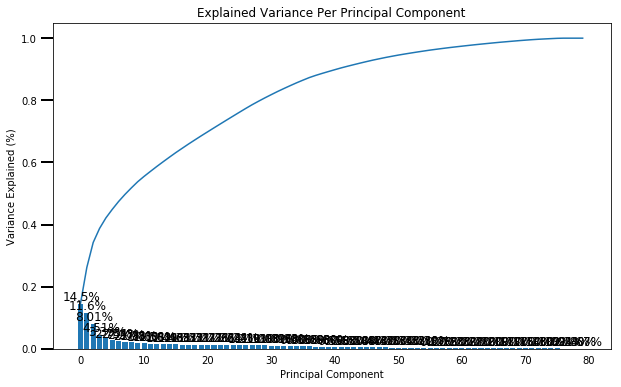

In [40]:
scree_plot(pca)

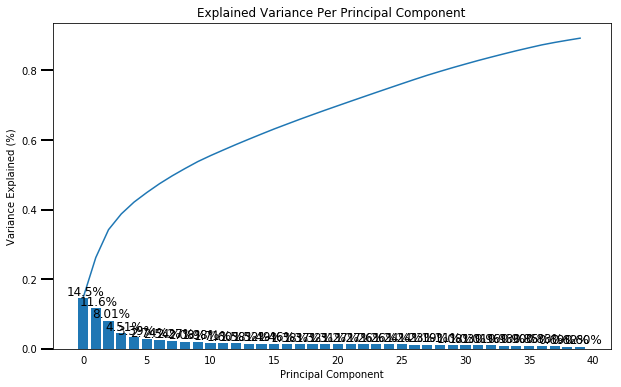

In [41]:
pca = PCA(n_components=40)
azdias_pca = pca.fit_transform(azdias)
scree_plot(pca)

### Discussion 2.2: Perform Dimensionality Reduction

In principle component 1, FINANZ_MINIMALIST had the largest negative weight of about -3.27 and the largest positive weight was FINANZ_SPARER at about 1.74. As we would expect, if someone has low financial interest (high value for minimalist), then they are unlikely to be a money-saver (low value for sparer).

In principle component 2, FINANZ_UNAUFFAELLIGER had the largest negative weight of about -3.07 and the largest positive weight was FINANZ_MINIMALIST at about 3.53. Once again, financial typology is shown to play a large role in explaining the variance of the data. This time, the results are not as straightforward. Apparently a person that's financially inconspicious (high value for unauffaelliger) tend to have high financial interest (low value for minimalist).

In principle component 3, FINANZ_VORSORGER had the largest negative weight of about -3.07 and the largest positive weight was HEALTH_TYP at about 3.72. We see that yet again, a financial typology feature plays a huge role in  this principle component. This time, it's regarding whether a person is prepared or not and the trait it seems to be inversely related to is health typology. To be honest, I'm not completely sure I understand the labels. The higher the value of health type, the more carefree about sanitation the person seems to be is what I'm getting. So the more prepared a person is, the more serious about sanitation the person is as well. This makes sense, if I'm interpreting health types right.

### Step 2.3: Interpret Principal Components


In [96]:
def map_weights(pca, n_pca):
    d = dict(zip(pca[n_pca], col_names))
    sorted_d = {}
    for i in sorted (d.keys()):
        sorted_d[i] = d[i]
    return sorted_d
map_weights(azdias_pca, 1)

{-3.2748746756186695: 'FINANZ_MINIMALIST',
 -2.4618613885390683: 'FINANZ_VORSORGER',
 -1.6627076889033254: 'HEALTH_TYP',
 -1.522736162902778: 'SEMIO_MAT',
 -1.3827161349568762: 'KONSUMNAEHE',
 -1.2892437930580327: 'W_KEIT_KIND_HH',
 -1.1820473663883238: 'ANZ_PERSONEN',
 -1.0451717066873203: 'ANZ_TITEL',
 -1.0030344702309004: 'RETOURTYP_BK_S',
 -0.8101645469025307: 'HH_EINKOMMEN_SCORE',
 -0.72135024702125705: 'ANZ_HAUSHALTE_AKTIV',
 -0.60456135363585028: 'SEMIO_LUST',
 -0.45700495096808097: 'KBA05_ANTG1',
 -0.40423790563867595: 'ALTERSKATEGORIE_GROB',
 -0.39026999252037287: 'ANREDE_KZ',
 -0.38147497618872339: 'FINANZ_ANLEGER',
 -0.37685012183122757: 'GREEN_AVANTGARDE',
 -0.36528119781951501: 'SEMIO_FAM',
 -0.29023252948323192: 'KBA05_ANTG3',
 -0.25552976737080613: 'SEMIO_TRADV',
 -0.080505176166625447: 'FINANZ_UNAUFFAELLIGER',
 -0.072140935448321106: 'SEMIO_DOM',
 -0.052806120038890084: 'SEMIO_REL',
 -0.045793535444920423: 'VERS_TYP',
 -0.020433253414966449: 'SEMIO_KAEM',
 0.05883166215

In [107]:
map_weights(azdias_pca, 2)


{-3.0656966270125867: 'FINANZ_UNAUFFAELLIGER',
 -2.0527603146519446: 'RETOURTYP_BK_S',
 -1.9535510016003887: 'SEMIO_MAT',
 -1.3994458074642258: 'ANZ_HAUSHALTE_AKTIV',
 -1.379348588688744: 'SEMIO_SOZ',
 -1.229187444862518: 'SEMIO_VERT',
 -0.71431483043039412: 'SEMIO_RAT',
 -0.71039250656537078: 'KBA05_ANTG4',
 -0.57133872562784782: 'HEALTH_TYP',
 -0.55750181825210865: 'KBA05_ANTG1',
 -0.52057988709426917: 'GREEN_AVANTGARDE',
 -0.39303844111235975: 'W_KEIT_KIND_HH',
 -0.39301862419399952: 'MIN_GEBAEUDEJAHR',
 -0.3394849794492566: 'KONSUMNAEHE',
 -0.33881547432924319: 'SEMIO_PFLICHT',
 -0.2738683833192368: 'SEMIO_TRADV',
 -0.26510906907753973: 'SEMIO_LUST',
 -0.23548756314876132: 'KBA05_ANTG2',
 -0.20602358140789942: 'WOHNDAUER_2008',
 -0.036000933756126251: 'SEMIO_KRIT',
 -0.0069799383252651705: 'SEMIO_KULT',
 -0.0046550410659188376: 'FINANZ_HAUSBAUER',
 0.022417287493466408: 'VERS_TYP',
 0.027431631002855422: 'KBA05_ANTG3',
 0.1273462026601595: 'SEMIO_KAEM',
 0.14723547693429082: 'ALTER

In [108]:
map_weights(azdias_pca, 3)


{-3.0714264600122392: 'FINANZ_VORSORGER',
 -2.667331931670232: 'FINANZ_SPARER',
 -1.5535274489136823: 'KBA05_ANTG1',
 -1.4841048113215518: 'SEMIO_KULT',
 -1.4825252464360392: 'RETOURTYP_BK_S',
 -1.3845341115575422: 'SOHO_KZ',
 -1.2259088816222579: 'ANREDE_KZ',
 -1.163693408015759: 'WOHNDAUER_2008',
 -1.0251100878279393: 'FINANZ_MINIMALIST',
 -0.93695089045360958: 'FINANZ_UNAUFFAELLIGER',
 -0.70469568120706161: 'SEMIO_ERL',
 -0.63326537471765387: 'ANZ_HH_TITEL',
 -0.61626196029994396: 'ALTERSKATEGORIE_GROB',
 -0.43195526575444443: 'SEMIO_KRIT',
 -0.3826164970724657: 'SEMIO_SOZ',
 -0.26542750056843395: 'HH_EINKOMMEN_SCORE',
 -0.15946136314244649: 'SEMIO_REL',
 -0.12213141890451511: 'MIN_GEBAEUDEJAHR',
 -0.10388360145880722: 'ANZ_HAUSHALTE_AKTIV',
 -0.091087385075038441: 'W_KEIT_KIND_HH',
 -0.047565881517341244: 'GREEN_AVANTGARDE',
 0.045906413026035452: 'SEMIO_VERT',
 0.053046583106142811: 'KBA05_ANTG4',
 0.16770706377565586: 'FINANZ_HAUSBAUER',
 0.21189508854845915: 'SEMIO_DOM',
 0.2134

### Discussion 2.3: Interpret Principal Components

In principle component 1, FINANZ_MINIMALIST had the largest negative weight of about -3.27 and the largest positive weight was FINANZ_SPARER at about 1.74. As we would expect, if someone has low financial interest (high value for minimalist), then they are unlikely to be a money-saver (low value for sparer).

In principle component 2, FINANZ_UNAUFFAELLIGER had the largest negative weight of about -3.07 and the largest positive weight was FINANZ_MINIMALIST at about 3.53. Once again, financial typology is shown to play a large role in explaining the variance of the data. This time, the results are not as straightforward. Apparently a person that's financially inconspicious (high value for unauffaelliger) tend to have high financial interest (low value for minimalist).

In principle component 3, FINANZ_VORSORGER had the largest negative weight of about -3.07 and the largest positive weight was HEALTH_TYP at about 3.72. We see that yet again, a financial typology feature plays a huge role in  this principle component. This time, it's regarding whether a person is prepared or not and the trait it seems to be inversely related to is health typology. To be honest, I'm not completely sure I understand the labels. The higher the value of health type, the more carefree about sanitation the person seems to be is what I'm getting. So the more prepared a person is, the more serious about sanitation the person is as well. This makes sense, if I'm interpreting health types right.


## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population


In [70]:
cluster_dists = []
for i in range(25, 30, 2):
    print(i)
    model = KMeans(i)
    preds = model.fit_predict(azdias_pca)
    
    cluster_dists.append(model.score(azdias_pca))
    
print(cluster_dists)

25
27
29
[-24176118.455147076, -23008762.253459353, -23000155.387153927]


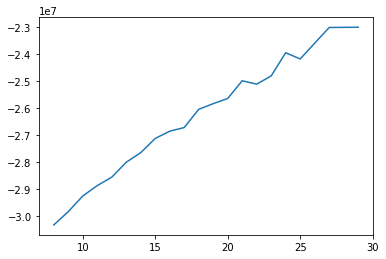

In [72]:
saved_cluster_dists = [-30328733.980154436, -29836481.097440597, -29255989.025775455, -28871209.864524931, -28558307.279963221, -28004665.243403275, -27648680.14033284, -27122167.318700481, -26854827.172818899, -26717697.170145266, -26043279.92856231, -25832157.348281562, -25641198.156853046, -24984812.076535579, -25110669.665933907, -24804386.386623822, -23944218.656318277, -24176118.455147076, -23008762.253459353, -23000155.387153927]
clusters = list(range(8,25))
clusters.extend([25, 27, 29])
plt.plot(clusters, saved_cluster_dists)


In [92]:
km_model = KMeans(26)
azdias_preds = km_model.fit_predict(azdias_pca)


### Discussion 3.1: Apply Clustering to General Population

There's not a very conspicious elbow in the graph, so I simply picked the second highest point which was 26. I did try a couple cluster values that were such as 15, 20, 24, and 27. When I used the kmeans fit to 15 clusters on the customer data, there was only one cluster, and as I increased the cluster values, a few more clusters appeared in the customer data but one cluster dominates the majority of the data. However, at 27, the clusters in the customer data dropped right back to one, so I think 27 clusters overfitted a bit. With cluster values 24 and 26, often times the clusters for customer data would flutuate between 2 and 4 clusters. I decided to stop with 4 clusters because it seemed more interesting to talk about.


### Step 3.2: Apply All Steps to the Customer Data


In [56]:
customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', sep=";")
customers.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,2,4,1,5.0,5,1,5,1,2,2,...,3.0,3.0,1.0,0.0,1.0,5.0,5.0,1.0,2.0,1.0
1,-1,4,1,NaN,5,1,5,1,3,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,-1,4,2,2.0,5,1,5,1,4,4,...,2.0,3.0,3.0,1.0,3.0,3.0,2.0,3.0,5.0,3.0
3,1,4,1,2.0,5,1,5,2,1,2,...,3.0,2.0,1.0,0.0,1.0,3.0,4.0,1.0,3.0,1.0
4,-1,3,1,6.0,3,1,4,4,5,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,3.0,5.0,1.0


In [58]:
customers = clean_data(customers)

   ALTERSKATEGORIE_GROB  ANREDE_KZ  CJT_GESAMTTYP  FINANZ_MINIMALIST  \
0                   4.0          1            5.0                  5   
1                   4.0          1            NaN                  5   
2                   4.0          2            2.0                  5   
3                   4.0          1            2.0                  5   
4                   3.0          1            6.0                  3   

   FINANZ_SPARER  FINANZ_VORSORGER  FINANZ_ANLEGER  FINANZ_UNAUFFAELLIGER  \
0              1                 5               1                      2   
1              1                 5               1                      3   
2              1                 5               1                      4   
3              1                 5               2                      1   
4              1                 4               4                      5   

   FINANZ_HAUSBAUER  FINANZTYP    ...     PLZ8_ANTG1  PLZ8_ANTG2  PLZ8_ANTG3  \
0                 2     

In [59]:
customers.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,LP_FAMILIE_FEIN_6.0,LP_FAMILIE_FEIN_7.0,LP_FAMILIE_FEIN_8.0,LP_FAMILIE_FEIN_9.0,LP_FAMILIE_FEIN_10.0,LP_FAMILIE_FEIN_11.0,Decade,Movement,Wealth,Lifestage
0,4.0,1,5,1,5,1,2,2,1,1.0,...,0,0,0,0,0,0,2,1,1,3
2,4.0,2,5,1,5,1,4,4,1,2.0,...,0,0,0,0,0,0,2,1,3,4
4,3.0,1,3,1,4,4,5,2,0,3.0,...,0,0,0,0,1,0,4,0,4,1
5,3.0,1,5,1,5,1,2,3,1,3.0,...,0,0,0,0,0,0,2,1,3,4
6,4.0,1,5,1,5,1,1,2,1,2.0,...,0,0,0,0,0,0,2,1,2,3


In [93]:
customers_pca = pca.transform(customers)
customers_preds = km_model.predict(customers_pca)

### Step 3.3: Compare Customer Data to Demographics Data


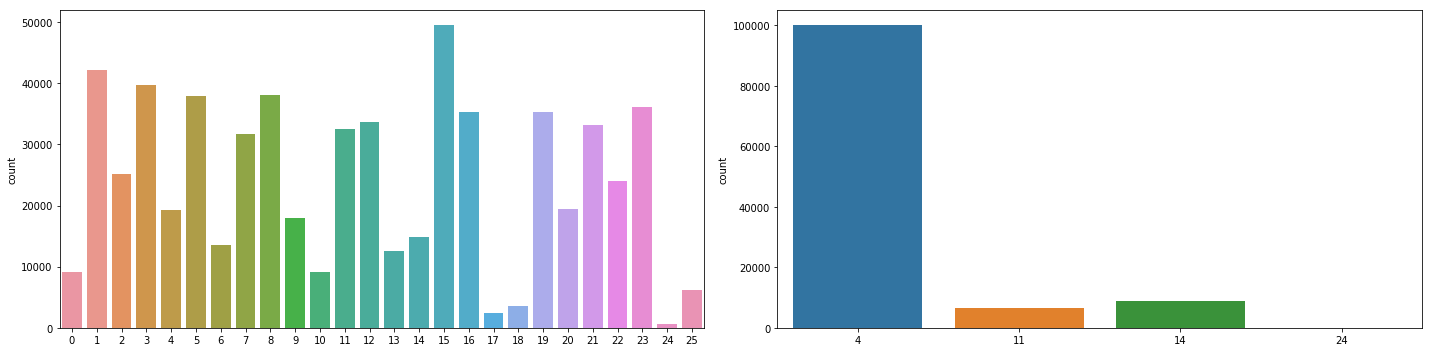

In [94]:
f, axes = plt.subplots(1, 2, figsize=(20, 5))
sns.countplot(x = azdias_preds, ax=axes[0])
sns.countplot(x = customers_preds, ax=axes[1])
plt.tight_layout()


In [116]:
azdias_preds

array([ 0,  5, 19, ..., 21, 23,  8], dtype=int32)

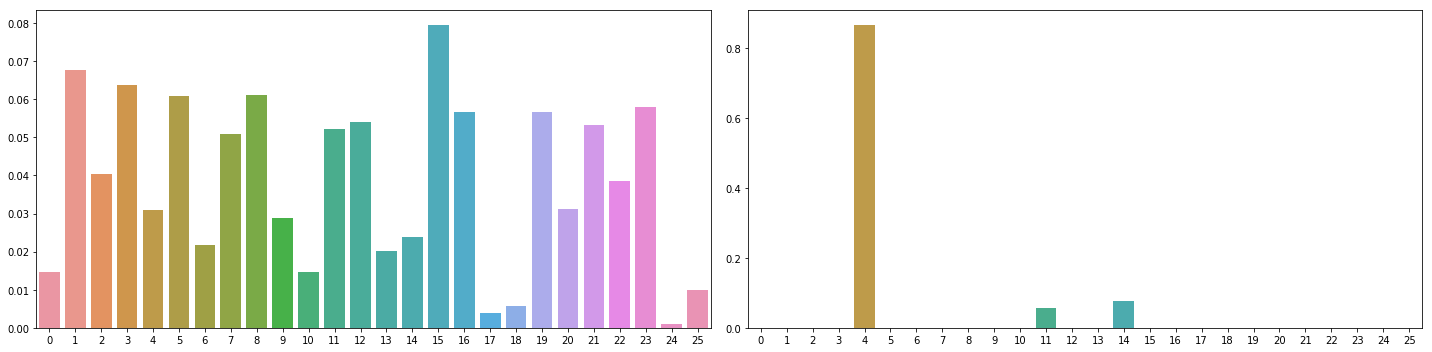

In [122]:
#plot in percentages
azdias_preds_perc = [np.sum(azdias_preds == i)/len(azdias_preds) for i in range(26)]
customers_preds_perc = [np.sum(customers_preds == i)/len(customers_preds) for i in range(26)]
f, axes = plt.subplots(1, 2, figsize=(20, 5))
c_clusters = list(range(26))
sns.barplot(x = c_clusters, y = azdias_preds_perc, ax=axes[0])
sns.barplot(x = c_clusters, y = customers_preds_perc, ax=axes[1])
plt.tight_layout()

In [149]:
def map_cluster(cluster):
    d = dict(zip(cluster, col_names))
    sorted_d = {}
    for i in sorted (d.keys()):
        sorted_d[i] = d[i]
    return sorted_d

In [152]:
#overrepresented
clu4=standard_scaler.inverse_transform(pca.inverse_transform(km_model.cluster_centers_[4]))
print(map_cluster(clu4))

{-0.024756361013675884: 'FINANZTYP_4', -0.020685962110566836: 'FINANZTYP_1', -0.0014521685515495042: 'KBA05_ANTG4', 6.3729700777267161e-05: 'ANZ_TITEL', 0.00021939151321451363: 'LP_FAMILIE_FEIN_5.0', 0.00043737476672112054: 'LP_FAMILIE_FEIN_3.0', 0.00048372881041766624: 'ANZ_HH_TITEL', 0.00073902821557143665: 'LP_FAMILIE_FEIN_6.0', 0.00083998335998519864: 'LP_FAMILIE_FEIN_4.0', 0.0010064172626677963: 'LP_FAMILIE_FEIN_7.0', 0.0017806066023005052: 'FINANZTYP_6', 0.0030738378798962213: 'LP_FAMILIE_FEIN_8.0', 0.0093115713328794404: 'SOHO_KZ', 0.021290848415511571: 'FINANZTYP_2', 0.024360107378618365: 'LP_FAMILIE_FEIN_9.0', 0.040876311549409086: 'FINANZTYP_5', 0.044248731215902892: 'KBA05_ANTG3', 0.10801371549448222: 'LP_FAMILIE_FEIN_2.0', 0.20894462445572171: 'LP_FAMILIE_FEIN_11.0', 0.31462164485857308: 'PLZ8_ANTG4', 0.31701144170433426: 'LP_FAMILIE_FEIN_1.0', 0.33535407796878591: 'LP_FAMILIE_FEIN_10.0', 0.50454551362899669: 'GREEN_AVANTGARDE', 0.50454551362899702: 'Movement', 0.9169421725

In [154]:
#underrepresented
clu15=standard_scaler.inverse_transform(pca.inverse_transform(km_model.cluster_centers_[15]))
print(map_cluster(clu15))

{-0.02398600784777466: 'FINANZTYP_1', -0.0042313389769966098: 'FINANZTYP_4', -0.00075378929431367363: 'LP_FAMILIE_FEIN_5.0', -0.00047908487417429313: 'FINANZTYP_3', -0.00021847571479978109: 'ANZ_TITEL', 4.4400024419334605e-05: 'LP_FAMILIE_FEIN_8.0', 0.00051286993310695889: 'LP_FAMILIE_FEIN_3.0', 0.00060383641326933538: 'LP_FAMILIE_FEIN_6.0', 0.00080070735381570189: 'LP_FAMILIE_FEIN_4.0', 0.00087386506556080823: 'LP_FAMILIE_FEIN_7.0', 0.0051096032481304302: 'ANZ_HH_TITEL', 0.010100450125136303: 'SOHO_KZ', 0.014317777436631152: 'LP_FAMILIE_FEIN_9.0', 0.021859737221666897: 'GREEN_AVANTGARDE', 0.021859737221666925: 'Movement', 0.022435609416500524: 'KBA05_ANTG4', 0.093398451311650893: 'FINANZTYP_5', 0.095399931412897265: 'KBA05_ANTG3', 0.09542661108556709: 'LP_FAMILIE_FEIN_11.0', 0.12199546006291995: 'PLZ8_ANTG4', 0.20679048539627365: 'LP_FAMILIE_FEIN_2.0', 0.21485970418336026: 'LP_FAMILIE_FEIN_10.0', 0.30216452189827481: 'FINANZTYP_2', 0.46652353240230959: 'LP_FAMILIE_FEIN_1.0', 0.6331334

### Discussion 3.3: Compare Customer Data to Demographics Data

The company's customer base is clearly not universal. In fact, most of the customer base is in cluster 4 with very few in 3 other clusters. Cluster 4 is clearly the target audience for the company while the other clusters are not. I'll be looking at cluster 4 which is overrepresented in the customer dataset, and also at cluster 15 which is underrepresented by the dataset. 

As shown by the two sets of histograms, cluster 4 contains nearly 100,000 (90%) of the datapoints in the customer dataset while it only encompasses near 20,000 (3%) of the datapoints in the general dataset. I'll be looking at cluster 15 as the underrepresented cluster since the other existent clusters in the customer dataset, though are small, correspond pretty closely to the general dataset. Cluster 11 contains less than 10,000 (5%) of the datapoints in the customer dataset and contains near 35,000 (5.5%) in the general dataset. Cluster 14 contains near than 10,000 (8%) of the datapoints in the customer dataset and contains near 12,000 (2%) in the general dataset. It's actually slightly overrepresented. And cluster 24 which isn't even visible on the customer dataset histograms has a total of 81 datapoints, making up 0.007% of the customer dataset, and it also makes up a very low percentage of the general dataset. Hence, for the truly underrepresented cluster, I'll be looking at cluster 15, which makes up the greatest percentage of the general dataset, near 8%, but doesn't make up any part of the customer dataset.

My method of looking at the kinds of people typified by these clusters is to use inverse transform on the cluster centers to transform them back to the original data space, map them to the column variables, then sort them so that the highest column variables could be easily seen. 

The centroid of cluster 4 has KBA13_ANZAHL_PKW - 693.56 (Number of cars in the PLZ8 region) and MIN_GEBAEUDEJAHR - 1992.96 (First year building was mentioned in the database) as its highest values. However, this is only because the values themselves are high in the first place since they measure number of cars and the other is a year number. The other values that were high are mostly of the SEMIO series: SEMIO_MAT - 4.38 (materialistic), SEMIO_TRADV - 4.53 (traditional-minded), SEMIO_FAM - 4.97 (family-minded), SEMIO_REL - 5.01 (religious), SEMIO_VERT - 5.12 (dreamful), SEMIO_PFLICHT - 5.22 (dutiful), SEMIO_KULT - 5.35 (cultural-minded), SEMIO_SOZ - 5.66 (socially-minded). WOHNDAUER_2008 - 7.96 (Length of residence), Decade - 5.66 (around 80s to 90s), INNENSTADT - 5.34 (10-20km to city center). Some other interesting variables are ANZ_PERSONEN - 2.56 (number of adults in household), Lifestage - 3.39 (Families With School Age Children), Wealth - 2.34 (upper middle class), FINANZ_SPARER - 3.60, and FINANZ_MINIMALIST - 4.18.  So in general, the personality typology for this group is average affinity. There's an average of 693 cars in the region, the decade is around the 80s to 90s, and they live around 10-20km away from the center of the city. There's generally about 2-3 adults and some children in the household and they're of the upper middle class. In regards to their finances, they tend to have high financial interest and are average to low money-savers.



The centroid of cluster 15 also has KBA13_ANZAHL_PKW - 646.84 and MIN_GEBAEUDEJAHR - 1992.83 as its highest values and personality typology values are also similar to the centroid of cluster 4 with most values being average affinity. WOHNDAUER_2008 - 8.39 (Length of residence), Decade - 3.48 (around 60s to 70s), INNENSTADT - 8.39 (more than 40km to city center), ANZ_PERSONEN - 1.94 (number of adults in household), Lifestage - 3.33, Wealth - 2.57 (upper middle class), FINANZ_SPARER - 1.68, and FINANZ_MINIMALIST - 4.53. The population of this cluster are also of middle class wealth and in the stage of life where they are families with school age children. They are likely older than the group in cluster 4 as shown by the decade and length of residence values, and they live in slightly more spreadout households as shown by the number of adults in households. In regards to their finances, they tend to have high financial interest and are big on saving money. The greatest difference is probably their distance from the city center, they are more than 40km from the city center. This in addition to the fact that they're more interested in saving money compared to the people in cluster 4 might explain why they're not popular with the company, since it might cost a lot and take longer time to deliver to people that live far away from the city compared to those that live closer to the city.

